# Catalogue Scaling Laws

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import eqcat.parsers.isf_catalogue_reader as icr
import eqcat.catalogue_query_tools as cqt

In [2]:
# read the catalogue - why do we bother making an hdf5?
raw_file_name = "Marmaries-catalogue1.txt"
base = os.path.basename(raw_file_name)
db_file_name = os.path.splitext(base)[0] + '.hdf5'

rejection_keywords = ["mining", "geothermal", "explosion", "quarry", 
                      "reservoir", "induced", "rockburst"]
reader = icr.ISFReader(raw_file_name, 
                       rejection_keywords=rejection_keywords)
catalogue = reader.read_file("TUR", "ISC")

In [3]:
# summarize reasons for rejections
if not os.path.isfile(db_file_name) and len(reader.rejected_catalogue) > 0:
    num_rejections = len(reader.rejected_catalogue.events)
    keyword_counts = dict(zip(rejection_keywords, [0]*num_rejections))
    for event in reader.rejected_catalogue.events:
        for keyword in rejection_keywords:
            if keyword.lower() in event.comment.lower():
                keyword_counts[keyword] = keyword_counts[keyword] + 1

    num_keywords_found = sum(keyword_counts.values())
    print "Note: %d rejection keywords found in %d rejected events." % \
        (num_keywords_found, num_rejections)

    print keyword_counts

In [4]:
# build the catalogue if we haven't already
if not os.path.isfile(db_file_name):
    _ = catalogue.build_dataframe(db_file_name)
db1 = cqt.CatalogueDB(db_file_name)

In [5]:
pd.concat([db1.origins.head(), db1.origins.tail()])

eventID  originID Agency  year  month  day  hour  minute     second  \
0        16958138   1961785   GUTE  1911      4    4    15      43  54.000000   
1        16958138  05951201    ISC  1911      4    4    15      43  47.343750   
2          914160   1961791   GUTE  1911      4   30    20      42  30.000000   
3          914008   1961445    ISS  1914     10    3    22       6  34.000000   
4          914008  05951227    ISC  1914     10    3    22       7   7.359375   
128549  607661588  06221058    IDC  2015      7   30    10      43  26.265625   
128550  607677396  06222570   NEIC  2015      8   24    16       9  15.000000   
128551  607708908  06249192    NAO  2015      8   29    18      12  43.312500   
128552  607708908  06238676   NEIC  2015      8   29    18      12  49.000000   
128553  607708908  06238662    GFZ  2015      8   29    18      12  50.187500   

        time_error  longitude   latitude  depth  semimajor90  semiminor90  \
0             0.00  25.500000  36.500000    140     0.000000        0.000   
1             1.99  25.883499  36.406300     15    23.200001       16.840   
2             0.00  30.000000  36.000000    180     0.000000        0.000   
3             0.00  32.500000  37.500000    NaN     0.000000        0.000   
4             0.62  30.020800  37.629200     15    14.990000        7.741   
128549        4.36  25.373301  36.583302     90    59.599998       25.100   
128550        0.00  30.709000  36.972000     94     0.000000        0.000   
128551        0.00  27.709999  36.310001     33     0.000000        0.000   
128552        0.00  27.690001  36.284000     85     0.000000        0.000   
128553        0.00  27.700001  36.169998     86     0.000000        0.000   

        error_strike  depth_error  prime  
0                  0     0.000000      0  
1                 93     0.000000      1  
2                  0     0.000000      0  
3                  0     0.000000      0  
4                 27     0.000000      1  
128549           148    47.799999      1  
128550             0     0.000000      0  
128551             0     0.000000      0  
128552             0     0.000000      0  
128553             0     0.000000      1

In [6]:
pd.concat([db1.magnitudes.head(),db1.magnitudes.tail()])

eventID  originID              magnitudeID  value  sigma magType  \
0        16958138   1961785      1961785|PAS|7.00|MS    7.0    0.0      MS   
1          914160   1961791      1961791|PAS|6.20|MS    6.2    0.0      MS   
2          914008  05951227     05951227|ISC|7.20|MS    7.2    0.1      MS   
3          913203   1960505      1960505|PAS|6.50|MS    6.5    0.0      MS   
4          911975   1959125      1959125|PAS|6.80|MS    6.8    0.0      MS   
116525  607661588  06221058  06221058|IDC|3.50|mbtmp    3.5    0.2   mbtmp   
116526  607677396  06222570    06222570|NEIC|4.20|UK    4.2    0.0      UK   
116527  607708908  06249192     06249192|NAO|3.90|mb    3.9    0.0      mb   
116528  607708908  06238676    06238676|NEIC|4.00|UK    4.0    0.0      UK   
116529  607708908  06238662     06238662|GFZ|4.20|mb    4.2    0.0      mb   

       magAgency  
0            PAS  
1            PAS  
2            ISC  
3            PAS  
4            PAS  
116525       IDC  
116526      NEIC  
116527       NAO  
116528      NEIC  
116529       GFZ

In [7]:
db1.origins
temp = db1.origins["eventID"]
temp = list(temp)
uniqueIDs = set(temp)
print "Number of magnitudes: ", len(db1.magnitudes)
print "Number of origins: ", len(db1.origins)
print "Number of unique events: ", len(uniqueIDs)

Number of magnitudes:  116530
Number of origins:  128554
Number of unique events:  36179


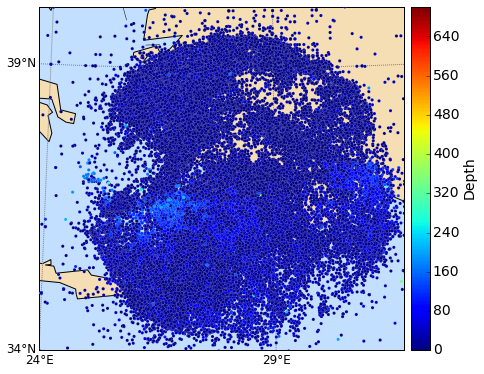

In [8]:
# Set up the configuration of the limits
outlier_fraction = 0.001
llon = np.floor(db1.origins.longitude.quantile(outlier_fraction))
ulon = np.ceil(db1.origins.longitude.quantile(1 - outlier_fraction))
llat = np.floor(db1.origins.latitude.quantile(2*outlier_fraction))
ulat = np.ceil(db1.origins.latitude.quantile(1 - 2*outlier_fraction))
map_config = {"llon": llon, "ulon": ulon, "llat": llat, "ulat": ulat, 
              "parallel": 5.0, "meridian": 5.0, "resolution": "l"}
cqt.plot_catalogue_map(map_config, db1)

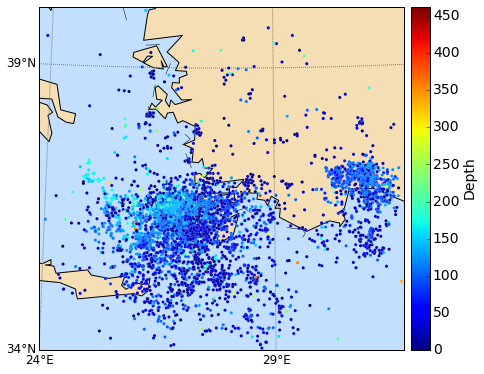

In [9]:
selector = cqt.CatalogueSelector(db1)
turkey_catalogue = selector.select_within_depth_range(100,600)
cqt.plot_catalogue_map(map_config, turkey_catalogue)

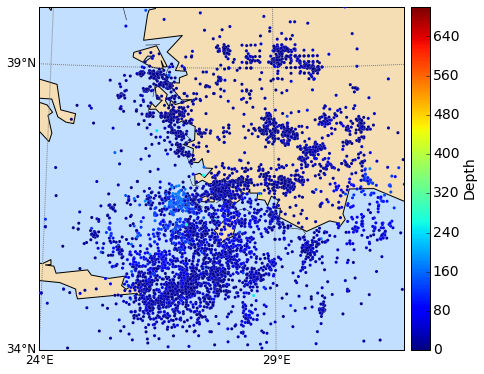

In [10]:
selector = cqt.CatalogueSelector(db1)
turkey_catalogue = selector.select_within_magnitude_range(5,8)
cqt.plot_catalogue_map(map_config, turkey_catalogue)

In [11]:
agency_magnitude_stats = cqt.get_agency_magtype_statistics(db1, quiet=True)

In [12]:
def count_magnitudes(mag, agency_magnitude_stats):
    # case-insensitive summary of which achency has a magnitude
    
    has_mag = {}
    mag = mag.lower()
    MAG = mag.upper()
    mags = [mag[0] + mag[1], mag[0] + MAG[1], 
            MAG[0] + mag[1], MAG[0] + MAG[1]]
    
    for i, agency in enumerate(agency_magnitude_stats):
        if agency_magnitude_stats[agency].has_key('Magnitudes'):
            n = 0
            for mag in mags:
                if agency_magnitude_stats[agency]['Magnitudes'].has_key(mag):
                    n = n + agency_magnitude_stats[agency]['Magnitudes'][mag]
            if n > 1:
                has_mag[agency] = n
    return has_mag

In [13]:
print 'Mw: ', len(count_magnitudes('Mw', agency_magnitude_stats))
print 'Md: ', len(count_magnitudes('Md', agency_magnitude_stats))
print 'Ms: ', len(count_magnitudes('Ms', agency_magnitude_stats))
print 'Ml: ', len(count_magnitudes('Ml', agency_magnitude_stats))
print 'Mb: ', len(count_magnitudes('Mb', agency_magnitude_stats))

Mw:  15
Md:  15
Ms:  23
Ml:  30
Mb:  44


In [14]:
agency_counts = count_magnitudes('MW', agency_magnitude_stats)
sorted(agency_counts.items(), key=lambda x: x[1], reverse=True)

[('NIC', 561),
 ('CSEM', 287),
 ('MED_RCMT', 218),
 ('ZUR_RMT', 84),
 ('GCMT', 53),
 ('HRVD', 40),
 ('NEIC', 29),
 ('DDA', 19),
 ('GII', 16),
 ('ISK', 6),
 ('BGS', 6),
 ('PDA', 4),
 ('THE', 4),
 ('GFZ', 2),
 ('DJA', 2)]

In [15]:
cqt.get_agency_magnitude_pairs(db1,('NEIC', 'MS'),('IDC', 'MS'),no_case=True);

Agency-Pairs: (NEIC, MS) & (IDC, MS) returned 40 events


In [16]:
# round 1
MW_ref = [('MED_RCMT', 'MW'), ('HRVD', 'MW'), ('ZUR_RMT', 'MW'), 
          ('GCMT', 'MW'), ('NEIC', 'MW')]
check = ('ISK', 'ML')
for ref in MW_ref:
    cqt.get_agency_magnitude_pairs(db1, check, ref, no_case=True)

Agency-Pairs: (ISK, ML) & (MED_RCMT, MW) returned 162 events
Agency-Pairs: (ISK, ML) & (HRVD, MW) returned 23 events
Agency-Pairs: (ISK, ML) & (ZUR_RMT, MW) returned 41 events
Agency-Pairs: (ISK, ML) & (GCMT, MW) returned 52 events
Agency-Pairs: (ISK, ML) & (NEIC, MW) returned 26 events


In [17]:
# round 2
MS_ref = [('IDC', 'MS'), ('ISC', 'MS'), ('ISCJB', 'MS'), 
              ('MOS', 'MS'), ('NEIC', 'MS')]
check = ('IDC', 'MS')
for ref in MS_ref:
    cqt.get_agency_magnitude_pairs(db1, check, ref)

Agency-Pairs: (IDC, MS) & (IDC, MS) returned 1279 events
Agency-Pairs: (IDC, MS) & (ISC, MS) returned 446 events
Agency-Pairs: (IDC, MS) & (ISCJB, MS) returned 397 events
Agency-Pairs: (IDC, MS) & (MOS, MS) returned 74 events
Agency-Pairs: (IDC, MS) & (NEIC, MS) returned 40 events


In [18]:
# round 3
MD_ref = [('ATH', 'MD'), ('ISK', 'MD')]
check = ('CSEM', 'MD')
for ref in MD_ref:
    cqt.get_agency_magnitude_pairs(db1, check, ref)

Agency-Pairs: (CSEM, MD) & (ATH, MD) returned 7743 events
Agency-Pairs: (CSEM, MD) & (ISK, MD) returned 8512 events


In [19]:
# round 3
ML_ref = [('ISK', 'ML'), ('ATH', 'ML'), ('THE', 'ML'), ('DDA', 'ML')]
check = ('CSEM', 'ML')
for ref in ML_ref:
    cqt.get_agency_magnitude_pairs(db1, check, ref)

Agency-Pairs: (CSEM, ML) & (ISK, ML) returned 1969 events
Agency-Pairs: (CSEM, ML) & (ATH, ML) returned 1272 events
Agency-Pairs: (CSEM, ML) & (THE, ML) returned 1562 events
Agency-Pairs: (CSEM, ML) & (DDA, ML) returned 167 events


In [20]:
references = [
    # considered "reference" MW after verification
    [('MED_RCMT', 'MW'), ('HRVD', 'MW')], # 218 events
    [('ZUR_RMT', 'MW'), ('HRVD', 'MW')], # 84 events
    [('GCMT', 'MW'), ('MED_RCMT', 'MW')], # 53 events
    [('NEIC', 'MW'), ('MED_RCMT', 'MW')], # 40 events
    [('NEIC', 'MW'), ('GCMT', 'MW')], # 29 events
]

comparisons = [
    # MW => reference MW
    [('NIC', 'MW'), ('MED_RCMT', 'MW')], # 85 overlap => 561 events
    [('CSEM', 'MW'), ('NIC', 'MW')], # 238 overlap => 287 events
    # MS => reference MW
    [('IDC', 'MS'), ('MED_RCMT', 'MW')], # 196 overlap => 1279 events
    [('ISC', 'MS'), ('MED_RCMT', 'MW')], # 149 overlap => 762 events
    [('ISCJB', 'MS'), ('MED_RCMT', 'MW')], # 79 overlap => 403 events
    [('MOS', 'MS'), ('MED_RCMT', 'MW')], # 64 overlap => 291 events
    [('BJI', 'MS'), ('MED_RCMT', 'MW')], # 125 overlap => 241 events
    [('CSEM', 'MS'), ('MED_RCMT', 'MW')], # 51 overlap => 128 events
    [('NEIC', 'MS'), ('MED_RCMT', 'MW')], # 29 overlap = > 65 events
    [('NEIC', 'MS'), ('HRVD', 'MW')], # 23 overlap = > 65 events
    # MD => reference MW
    [('ATH', 'MD'), ('MED_RCMT', 'MW')], # 87 overlap => 14988 events
    [('ISK', 'MD'), ('MED_RCMT', 'MW')], # 55 overlap => 17210 events
    [('HLW', 'MD'), ('MED_RCMT', 'MW')], # 40 overlap => 510 events
    [('DDA', 'MD'), ('MED_RCMT', 'MW')], # 23 overlap => 6172 events
    [('GII', 'MD'), ('MED_RCMT', 'MW')], # 34 overlap => 241 events
    # MD => MD => reference MW
    [('CSEM', 'MD'), ('ISK', 'MD')], # 8512 overlap => 10863 events
    # MB => reference MW
    [('ISC', 'MB'), ('MED_RCMT', 'MW')], # 182 overlap => 3953 events
    [('IDC', 'MB'), ('MED_RCMT', 'MW')], # 205 overlap => 2455 events
    [('NEIC', 'MB'), ('MED_RCMT', 'MW')], # 182 overlap => 1849 events
    [('ISCJB', 'MB'), ('MED_RCMT', 'MW')], # 91 overlap => 1161 events
    [('MOS', 'MB'), ('MED_RCMT', 'MW')], # 189 overlap => 936 events
    [('NIC', 'MB'), ('MED_RCMT', 'MW')], # 128 overlap => 689 events
    [('BJI', 'MB'), ('MED_RCMT', 'MW')], # 161 overlap => 602 events
    [('CSEM', 'MB'), ('MED_RCMT', 'MW')], # 120 overlap => 425 events
    # ML => reference MW
    [('ISK', 'ML'), ('MED_RCMT', 'MW')], # 162 overlap => 6545 events
    [('ATH', 'ML'), ('MED_RCMT', 'MW')], # 175 overlap => 6365 events
    [('THE', 'ML'), ('MED_RCMT', 'MW')], # 172 overlap => 4637 events
    [('DDA', 'ML'), ('MED_RCMT', 'MW')], # 73 overlap => 2999 events
    [('IDC', 'ML'), ('MED_RCMT', 'MW')], # 167 overlap => 2050 events
    [('NIC', 'ML'), ('MED_RCMT', 'MW')], # 129 overlap => 1147 events
    [('HLW', 'ML'), ('MED_RCMT', 'MW')], # 55 overlap => 589 events
    # ML => ML => reference MW   
    [('CSEM', 'ML'), ('ISK', 'ML')], # 1969 overlap => 2999 events
#    [("XXX","MM"), ("YYY", "NN")], # ZZZZ overlap => WWWW events
]

In [21]:
any([ref == MW_ref[0] for ref in MW_ref]) 

True

In [33]:
for pair in comparisons:

    from_agency = pair[0][0]
    from_mag = pair[0][1]
    to_agency = pair[1][0]
    to_mag = pair[1][1]
    
    # start function definition 
    print 'def from_%s_%s(M):' % (from_agency, from_mag)
    print '"""'

    # capture regression results as comments
    query, cat = cqt.get_agency_magnitude_pairs(
        db1, pair[0], pair[1], no_case=True)
    
    agency_counts = count_magnitudes(from_mag, agency_magnitude_stats)
    print 'Potential yeild %d magnitudes' % (agency_counts[from_agency])
    
    # do regression
    regressor = cqt.CatalogueRegressor(query)
    results = regressor.run_regression("polynomial", [0, 1])

    print '"""'

    # finish generating function definitions
    if any([ref == pair[1] for ref in MW_ref]):
        print "    return %.3f + %.3f*M" % (
            results.beta[0], results.beta[1])
    else:
        print "    return from_%s_%s(%.3f + %.3f*M)" % (
            to_agency, to_mag, results.beta[0], results.beta[1])
    print
        
    print 'def from_%s_%s_sigma(M):' % (from_agency, from_mag)
    
    _, _, st_dev = regressor.retrieve_model()
    if any([ref == pair[1] for ref in MW_ref]):
        print "    return %.3f" % st_dev
    else:
        print "    return math.sqrt(%.3f**2 + from_%s_%s_sigma(M)**2)" % (
            st_dev, to_agency, to_mag)
    print

def from_NIC_MW(M):
"""
Agency-Pairs: (NIC, MW) & (MED_RCMT, MW) returned 85 events
Potential yeild 561 magnitudes
"""
    return -2.058 + 1.717*M

def from_NIC_MW_sigma(M):
    return 0.336

def from_CSEM_MW(M):
"""
Agency-Pairs: (CSEM, MW) & (NIC, MW) returned 238 events
Potential yeild 287 magnitudes
"""
    return from_NIC_MW(0.928 + 0.721*M)

def from_CSEM_MW_sigma(M):
    return math.sqrt(0.144**2 + from_NIC_MW_sigma(M)**2)

def from_IDC_MS(M):
"""
Agency-Pairs: (IDC, MS) & (MED_RCMT, MW) returned 196 events
Potential yeild 1279 magnitudes
"""
    return 2.080 + 0.700*M

def from_IDC_MS_sigma(M):
    return 0.170

def from_ISC_MS(M):
"""
Agency-Pairs: (ISC, MS) & (MED_RCMT, MW) returned 149 events
Potential yeild 762 magnitudes
"""
    return 2.244 + 0.629*M

def from_ISC_MS_sigma(M):
    return 0.171

def from_ISCJB_MS(M):
"""
Agency-Pairs: (ISCJB, MS) & (MED_RCMT, MW) returned 79 events
Potential yeild 403 magnitudes
"""
    return 2.022 + 0.691*M

def from_ISCJB_MS_sigma(M):
 

In [31]:
print regressor.standard_deviation

None



Agency-Pairs: (NIC, MW) & (MED_RCMT, MW) returned 85 events


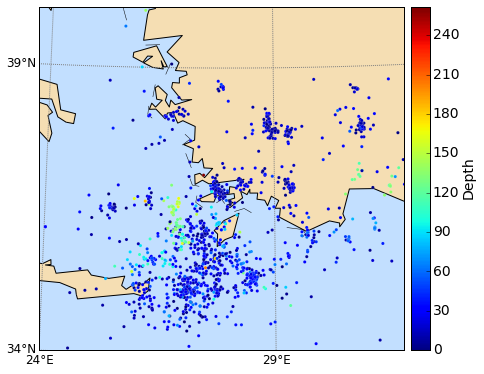

Beta: [-2.058304    1.71749651]
Beta Std Error: [ 0.73159022  0.18063894]
Beta Covariance: [[ 0.20186634 -0.04978088]
 [-0.04978088  0.01230696]]
Residual Variance: 2.65137940726
Inverse Condition #: 0.00120768944822
Reason(s) for Halting:
  Sum of squares convergence


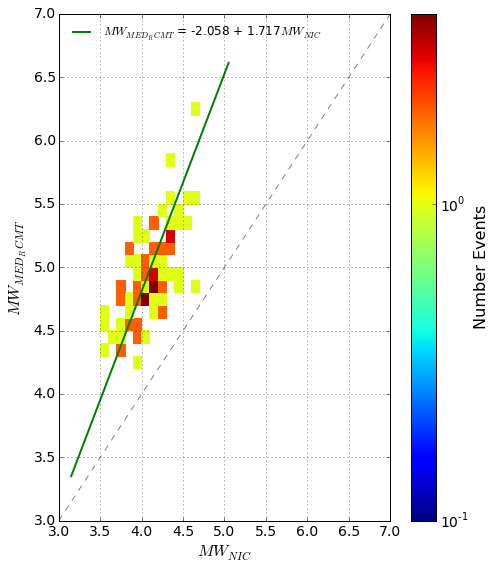

Model standard deviation is 0.336

Agency-Pairs: (CSEM, MW) & (NIC, MW) returned 238 events


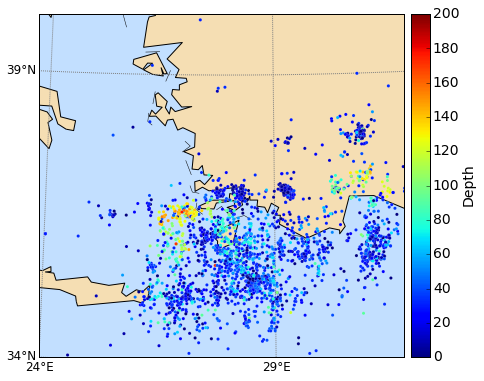

Beta: [ 0.92784287  0.72094527]
Beta Std Error: [ 0.07432543  0.02060716]
Beta Covariance: [[ 0.00437485 -0.0012033 ]
 [-0.0012033   0.0003363 ]]
Residual Variance: 1.26273249544
Inverse Condition #: 0.00340836201985
Reason(s) for Halting:
  Sum of squares convergence


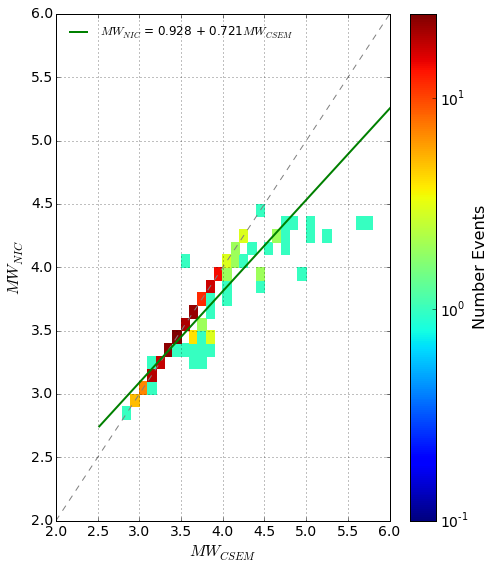

Model standard deviation is 0.144

Agency-Pairs: (IDC, MS) & (MED_RCMT, MW) returned 196 events


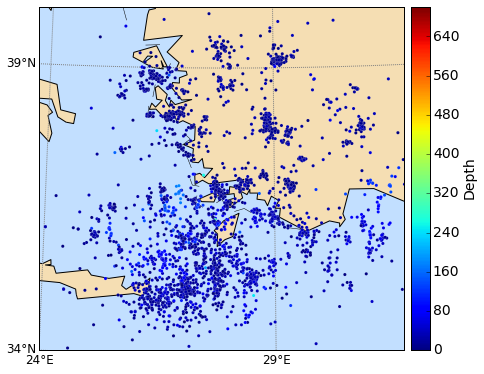

Beta: [ 2.07996157  0.69995384]
Beta Std Error: [ 0.08288593  0.02106244]
Beta Covariance: [[ 0.00409755 -0.00103086]
 [-0.00103086  0.00026459]]
Residual Variance: 1.67663157343
Inverse Condition #: 0.00350361680961
Reason(s) for Halting:
  Sum of squares convergence


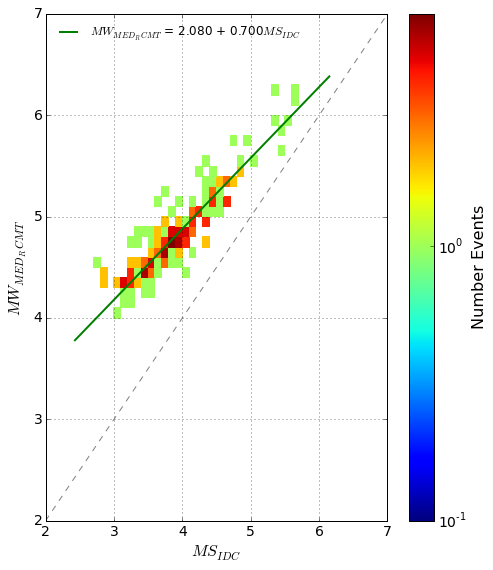

Model standard deviation is 0.17

Agency-Pairs: (ISC, MS) & (MED_RCMT, MW) returned 149 events


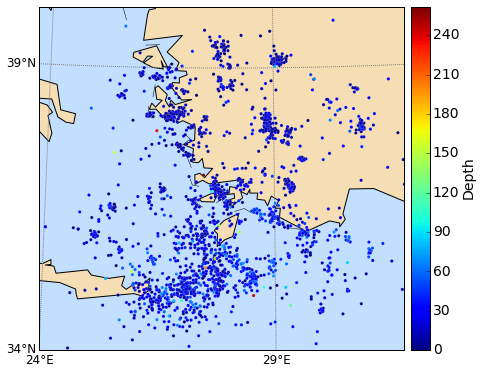

Beta: [ 2.24447876  0.62850009]
Beta Std Error: [ 0.11577588  0.02770806]
Beta Covariance: [[ 0.0066914  -0.0015889 ]
 [-0.0015889   0.00038326]]
Residual Variance: 2.00317577674
Inverse Condition #: 0.0029264955745
Reason(s) for Halting:
  Sum of squares convergence


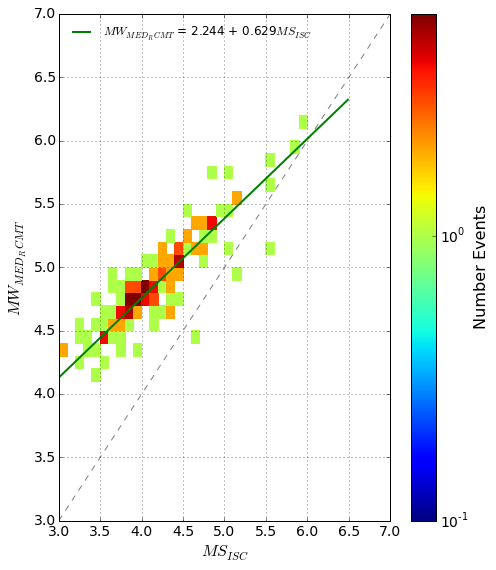

Model standard deviation is 0.171

Agency-Pairs: (ISCJB, MS) & (MED_RCMT, MW) returned 79 events


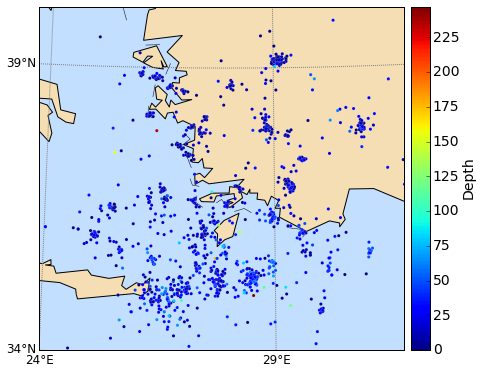

Beta: [ 2.02240687  0.6912699 ]
Beta Std Error: [ 0.16416724  0.04026463]
Beta Covariance: [[ 0.01210124 -0.00294499]
 [-0.00294499  0.00072795]]
Residual Variance: 2.22711785524
Inverse Condition #: 0.00298585844987
Reason(s) for Halting:
  Sum of squares convergence


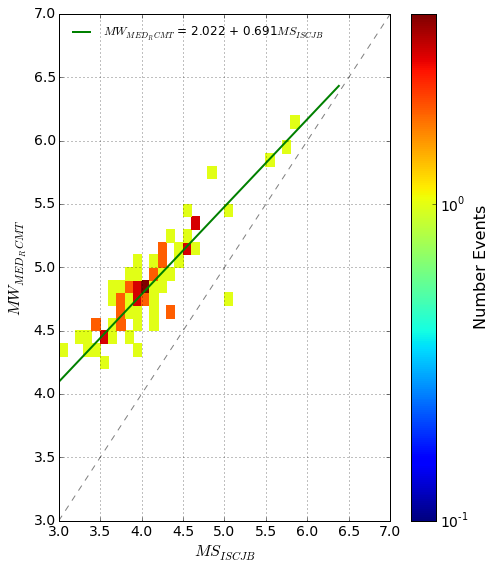

Model standard deviation is 0.179

Agency-Pairs: (MOS, MS) & (MED_RCMT, MW) returned 64 events


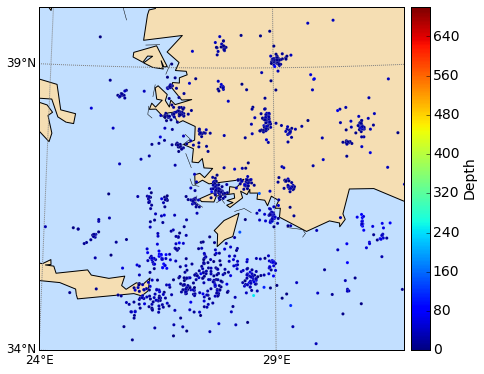

Beta: [ 1.61120117  0.79560226]
Beta Std Error: [ 0.25142125  0.05606841]
Beta Covariance: [[ 0.03088264 -0.0068585 ]
 [-0.0068585   0.00153584]]
Residual Variance: 2.04686640173
Inverse Condition #: 0.00198691408901
Reason(s) for Halting:
  Sum of squares convergence


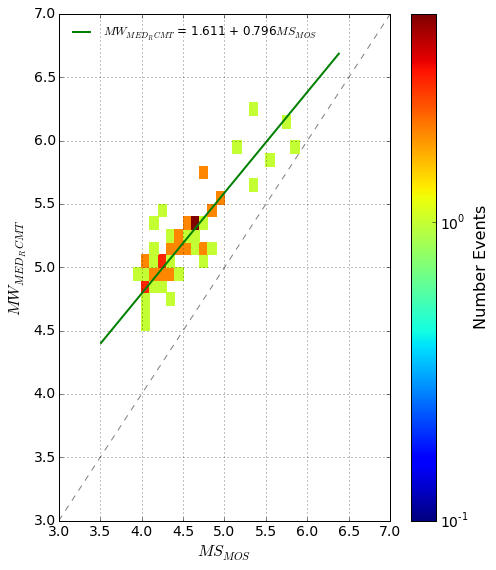

Model standard deviation is 0.18

Agency-Pairs: (BJI, MS) & (MED_RCMT, MW) returned 125 events


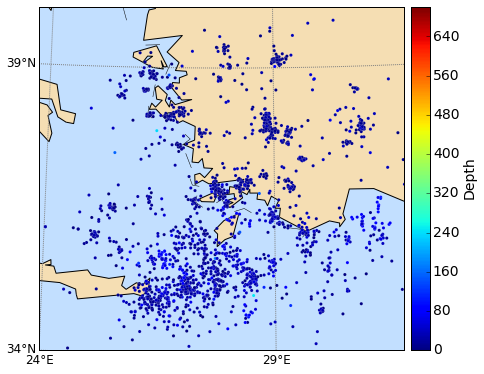

Beta: [-0.11527779  1.04215592]
Beta Std Error: [ 0.36641859  0.07521316]
Beta Covariance: [[ 0.03471159 -0.00710795]
 [-0.00710795  0.00146254]]
Residual Variance: 3.86794673337
Inverse Condition #: 0.00139666590703
Reason(s) for Halting:
  Sum of squares convergence


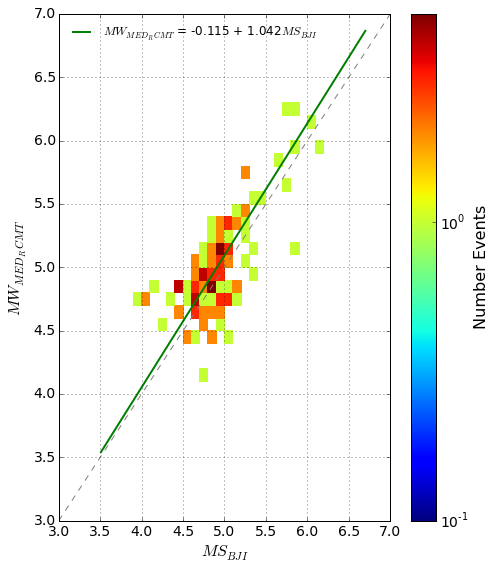

Model standard deviation is 0.282

Agency-Pairs: (CSEM, MS) & (MED_RCMT, MW) returned 51 events


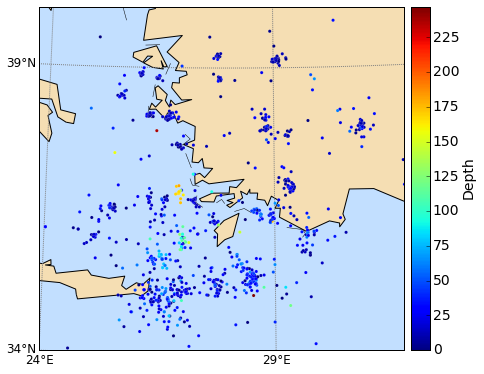

Beta: [ 2.84385945  0.53230815]
Beta Std Error: [ 0.11146033  0.028083  ]
Beta Covariance: [[ 0.00656538 -0.00162217]
 [-0.00162217  0.00041678]]
Residual Variance: 1.8922585467
Inverse Condition #: 0.00483677964484
Reason(s) for Halting:
  Sum of squares convergence


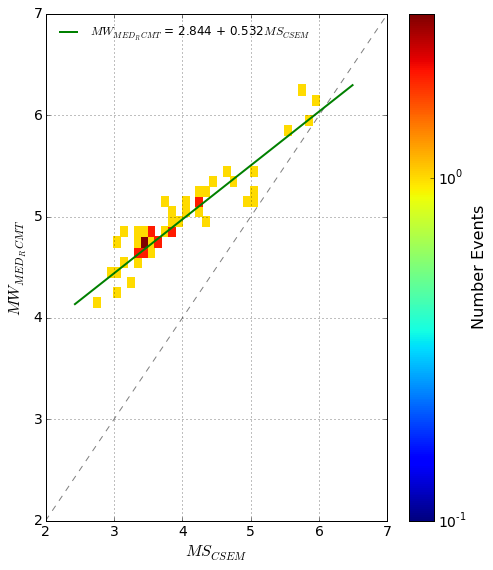

Model standard deviation is 0.153

Agency-Pairs: (NEIC, MS) & (MED_RCMT, MW) returned 29 events


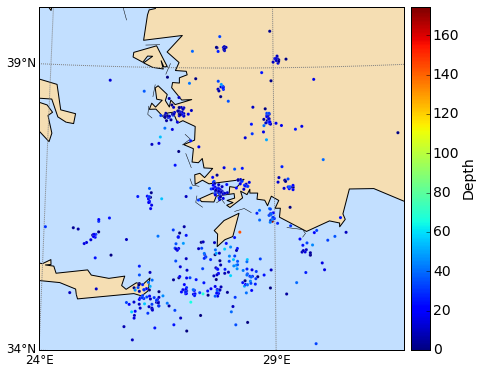

Beta: [ 2.34510787  0.61173979]
Beta Std Error: [ 0.28095886  0.05898142]
Beta Covariance: [[ 0.03899437 -0.00813616]
 [-0.00813616  0.00171849]]
Residual Variance: 2.02434041939
Inverse Condition #: 0.00227203166124
Reason(s) for Halting:
  Sum of squares convergence


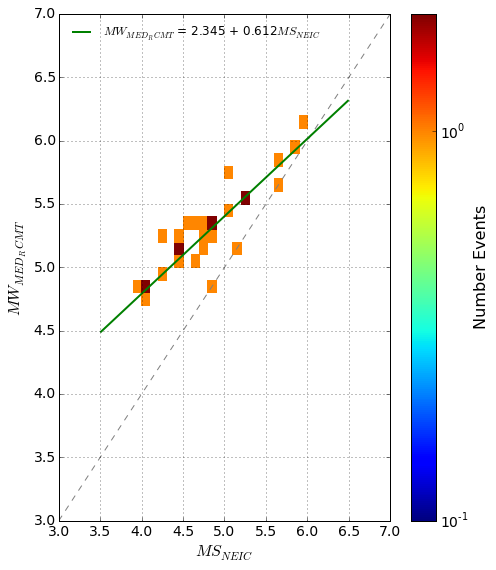

Model standard deviation is 0.161

Agency-Pairs: (NEIC, MS) & (HRVD, MW) returned 23 events


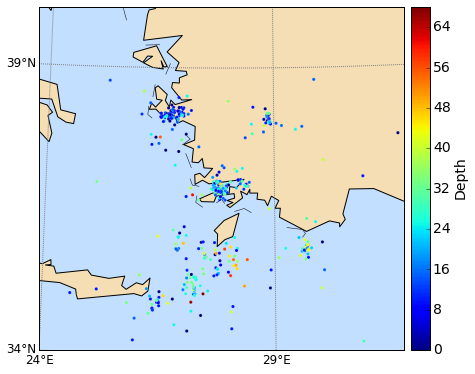

Beta: [ 2.38934824  0.60465831]
Beta Std Error: [ 0.39842723  0.08101227]
Beta Covariance: [[ 0.08077073 -0.01636265]
 [-0.01636265  0.00333932]]
Residual Variance: 1.96536864456
Inverse Condition #: 0.00171160912903
Reason(s) for Halting:
  Sum of squares convergence


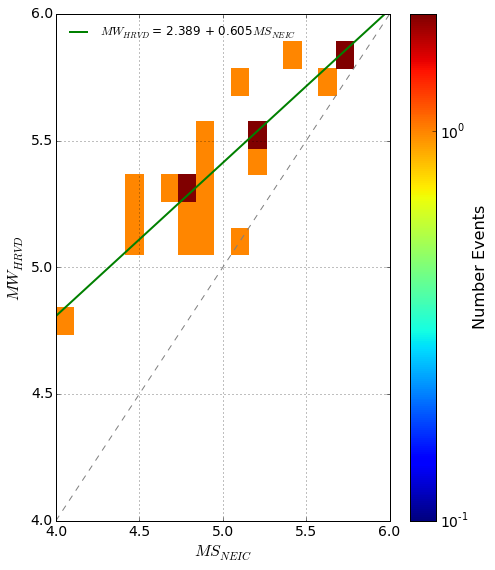

Model standard deviation is 0.157

Agency-Pairs: (ATH, MD) & (MED_RCMT, MW) returned 87 events


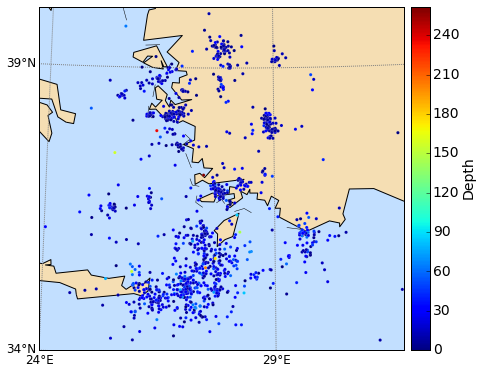

Beta: [ 0.24522111  1.02495679]
Beta Std Error: [ 0.40026754  0.08971252]
Beta Covariance: [[ 0.05288637 -0.01182705]
 [-0.01182705  0.00265674]]
Residual Variance: 3.02940258464
Inverse Condition #: 0.00146565960931
Reason(s) for Halting:
  Sum of squares convergence


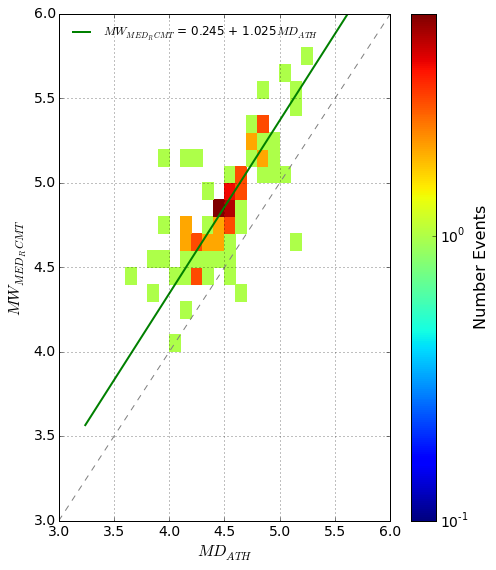

Model standard deviation is 0.246

Agency-Pairs: (ISK, MD) & (MED_RCMT, MW) returned 55 events


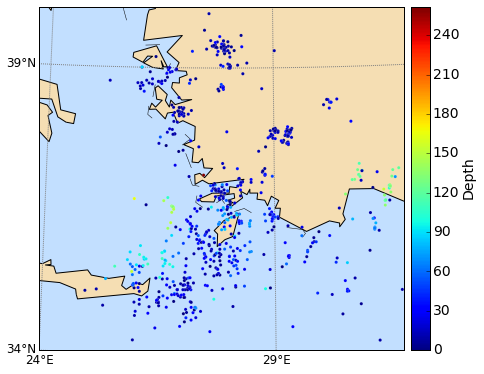

Beta: [ 0.00878801  1.07036432]
Beta Std Error: [ 0.47261279  0.10530373]
Beta Covariance: [[ 0.06347827 -0.01410019]
 [-0.01410019  0.00315139]]
Residual Variance: 3.51872963977
Inverse Condition #: 0.00171159138617
Reason(s) for Halting:
  Sum of squares convergence


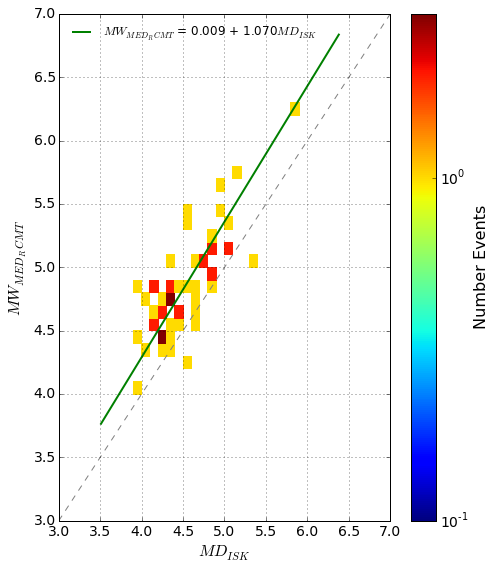

Model standard deviation is 0.27

Agency-Pairs: (HLW, MD) & (MED_RCMT, MW) returned 47 events


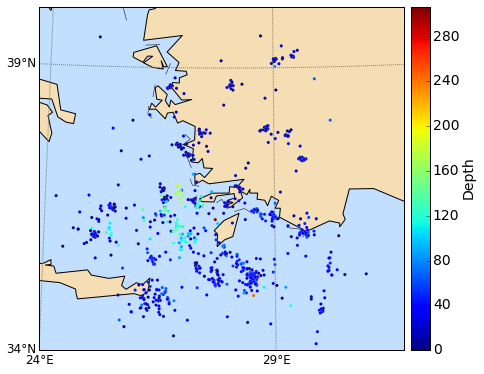

Beta: [ 4.60987188  0.03625082]
Beta Std Error: [ 0.14165075  0.03434153]
Beta Covariance: [[  1.57768386e-03  -3.55729168e-04]
 [ -3.55729168e-04   9.27302438e-05]]
Residual Variance: 12.7179697332
Inverse Condition #: 0.00878775418489
Reason(s) for Halting:
  Sum of squares convergence


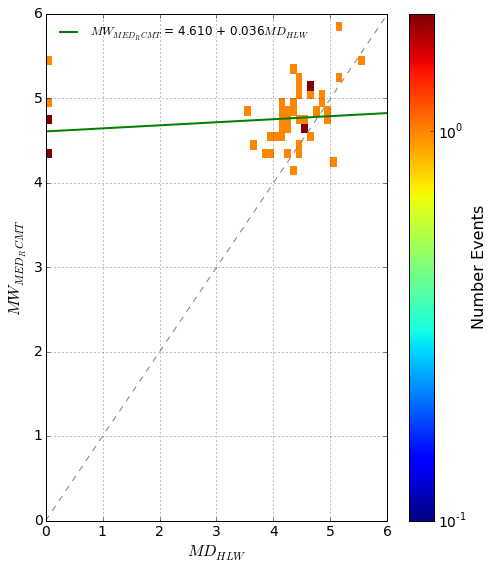

Model standard deviation is 0.349

Agency-Pairs: (DDA, MD) & (MED_RCMT, MW) returned 23 events


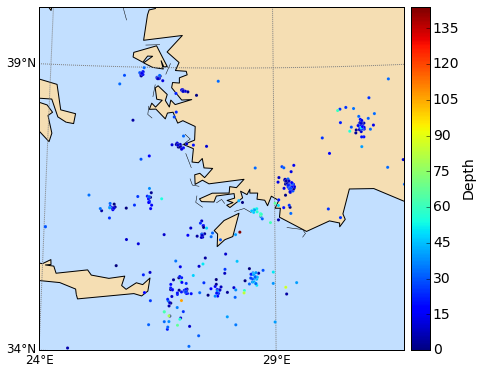

Beta: [ 2.58047778  0.51756035]
Beta Std Error: [ 0.35260595  0.08105951]
Beta Covariance: [[ 0.06153    -0.01408144]
 [-0.01408144  0.00325174]]
Residual Variance: 2.02065600137
Inverse Condition #: 0.0021317583643
Reason(s) for Halting:
  Sum of squares convergence


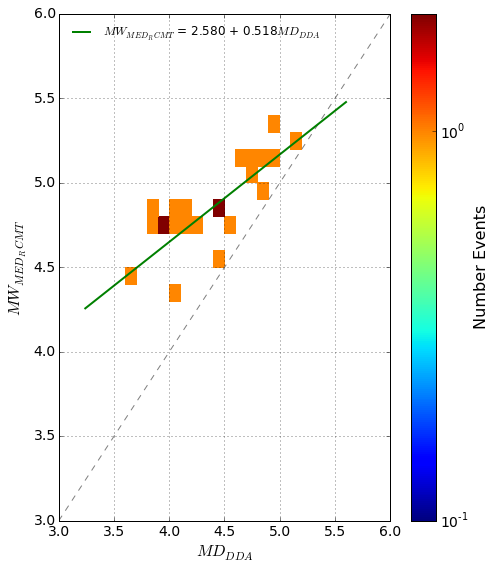

Model standard deviation is 0.153

Agency-Pairs: (GII, MD) & (MED_RCMT, MW) returned 34 events


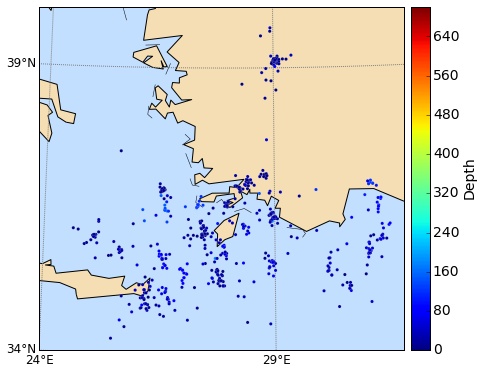

Beta: [ 1.38802338  0.77578496]
Beta Std Error: [ 0.39028049  0.08616189]
Beta Covariance: [[ 0.02419131 -0.00528843]
 [-0.00528843  0.00117906]]
Residual Variance: 6.29642822036
Inverse Condition #: 0.0030240627954
Reason(s) for Halting:
  Sum of squares convergence


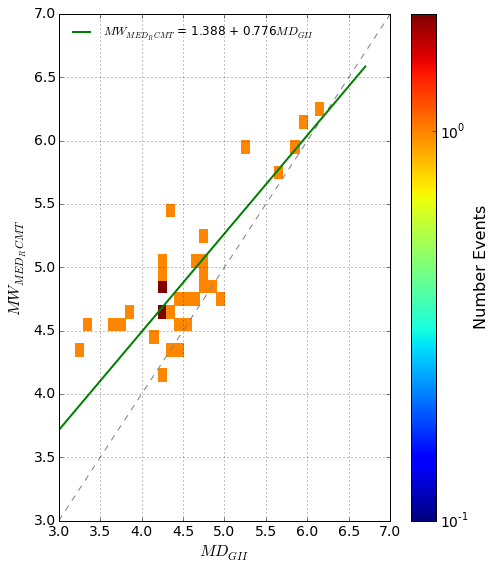

Model standard deviation is 0.308

Agency-Pairs: (CSEM, MD) & (ISK, MD) returned 8512 events


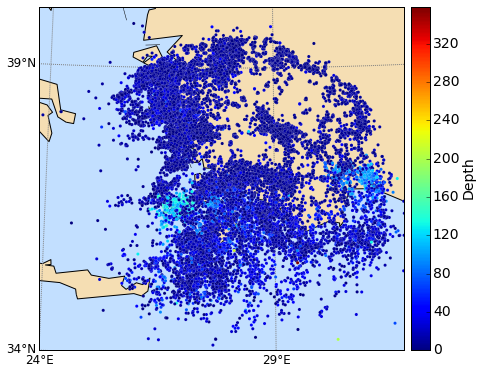

Beta: [-0.10421526  1.03098099]
Beta Std Error: [ 0.02036963  0.00653163]
Beta Covariance: [[  5.15965076e-04  -1.65057791e-04]
 [ -1.65057791e-04   5.30513993e-05]]
Residual Variance: 0.804166190567
Inverse Condition #: 0.002134213305
Reason(s) for Halting:
  Sum of squares convergence


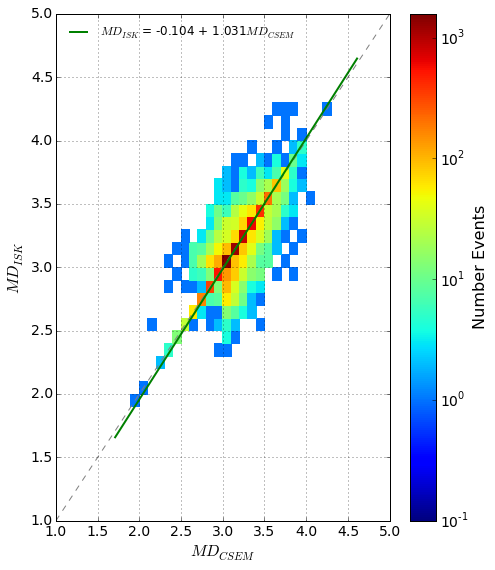

Model standard deviation is 0.129

Agency-Pairs: (ISC, MB) & (MED_RCMT, MW) returned 182 events


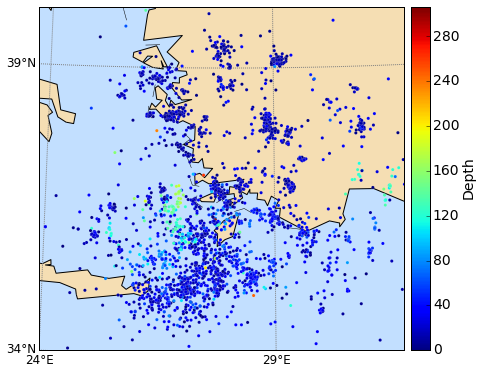

Beta: [ 0.10843193  1.01474864]
Beta Std Error: [ 0.2249705   0.04832563]
Beta Covariance: [[ 0.02527175 -0.0054131 ]
 [-0.0054131   0.00116611]]
Residual Variance: 2.00269956344
Inverse Condition #: 0.00159024294009
Reason(s) for Halting:
  Sum of squares convergence


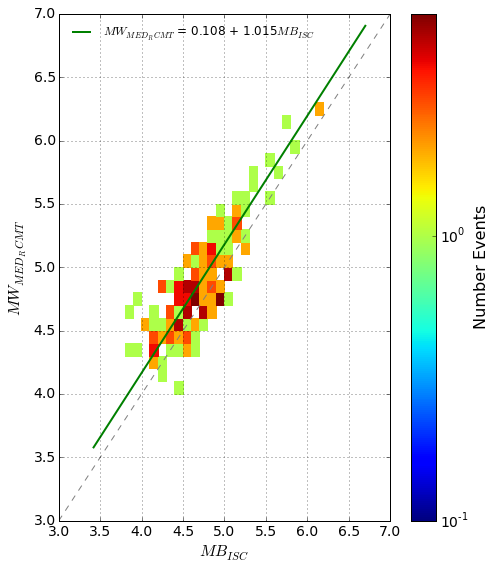

Model standard deviation is 0.224

Agency-Pairs: (IDC, MB) & (MED_RCMT, MW) returned 205 events


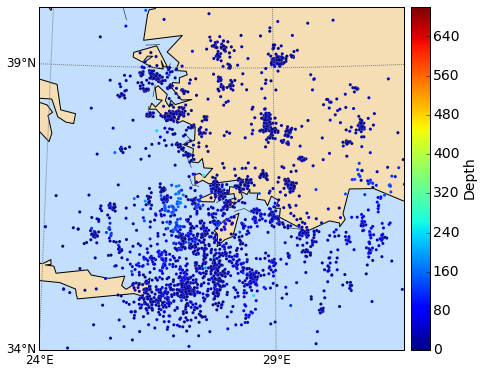

Beta: [ 0.19706576  1.05590094]
Beta Std Error: [ 0.20325393  0.04670147]
Beta Covariance: [[ 0.01487726 -0.00340646]
 [-0.00340646  0.00078543]]
Residual Variance: 2.77686696894
Inverse Condition #: 0.00187404347784
Reason(s) for Halting:
  Sum of squares convergence


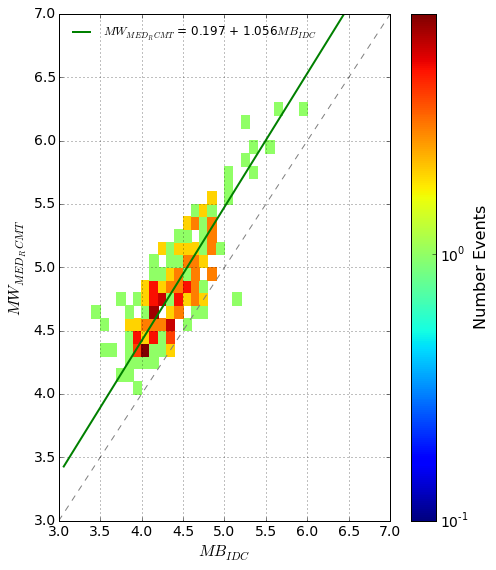

Model standard deviation is 0.241

Agency-Pairs: (NEIC, MB) & (MED_RCMT, MW) returned 182 events


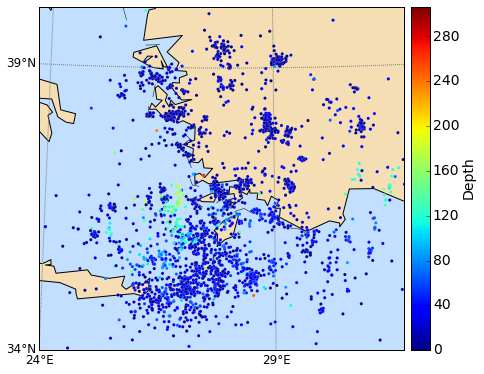

Beta: [ 0.11328164  1.00490874]
Beta Std Error: [ 0.21425753  0.04562306]
Beta Covariance: [[ 0.01804154 -0.00382991]
 [-0.00382991  0.00081803]]
Residual Variance: 2.54447730811
Inverse Condition #: 0.00163395429748
Reason(s) for Halting:
  Sum of squares convergence


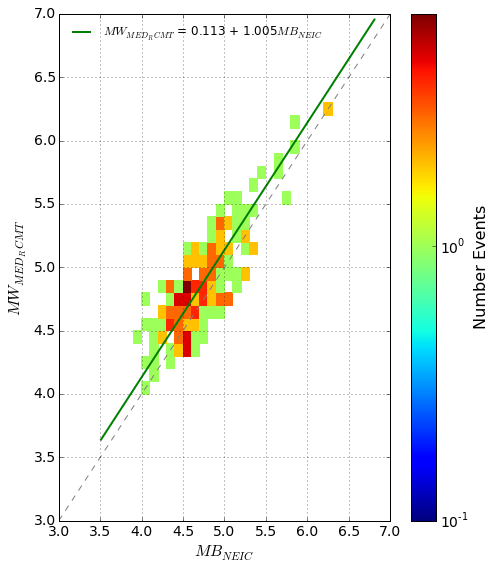

Model standard deviation is 0.225

Agency-Pairs: (ISCJB, MB) & (MED_RCMT, MW) returned 91 events


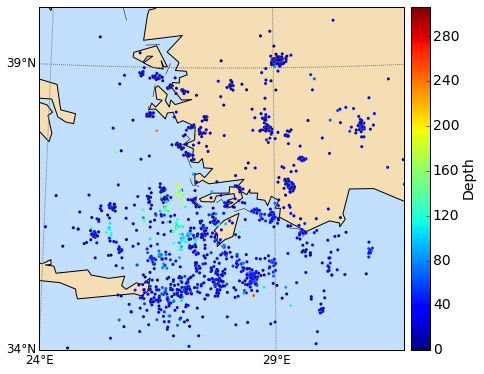

Beta: [ 0.11001337  1.01709987]
Beta Std Error: [ 0.26236826  0.05660731]
Beta Covariance: [[ 0.034365   -0.00739027]
 [-0.00739027  0.0015997 ]]
Residual Variance: 2.00311662352
Inverse Condition #: 0.00170650630445
Reason(s) for Halting:
  Sum of squares convergence


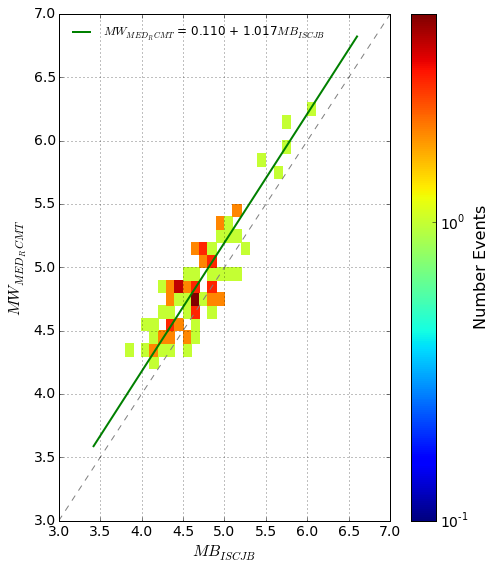

Model standard deviation is 0.2

Agency-Pairs: (MOS, MB) & (MED_RCMT, MW) returned 189 events


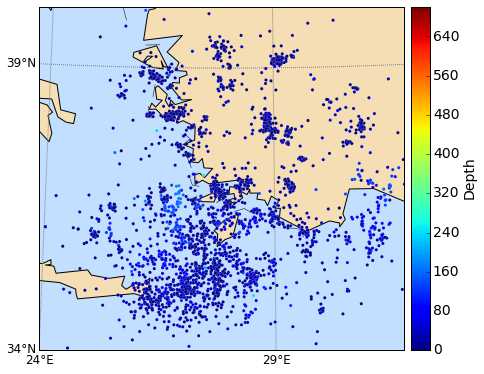

Beta: [ 0.33374026  0.9270676 ]
Beta Std Error: [ 0.20094726  0.04134009]
Beta Covariance: [[ 0.01461606 -0.00299677]
 [-0.00299677  0.0006186 ]]
Residual Variance: 2.7627018625
Inverse Condition #: 0.00165667878648
Reason(s) for Halting:
  Sum of squares convergence


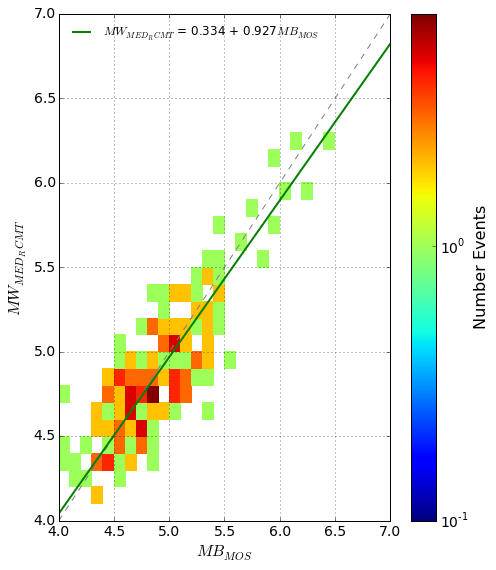

Model standard deviation is 0.225

Agency-Pairs: (NIC, MB) & (MED_RCMT, MW) returned 128 events


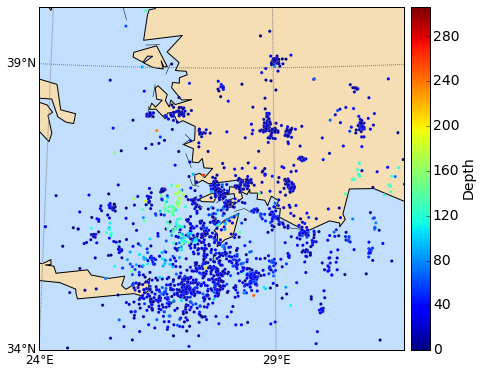

Beta: [-1.95672194  1.41602178]
Beta Std Error: [ 0.46718536  0.09683932]
Beta Covariance: [[ 0.08678973 -0.0179652 ]
 [-0.0179652   0.00372901]]
Residual Variance: 2.51483848767
Inverse Condition #: 0.00106673572239
Reason(s) for Halting:
  Sum of squares convergence


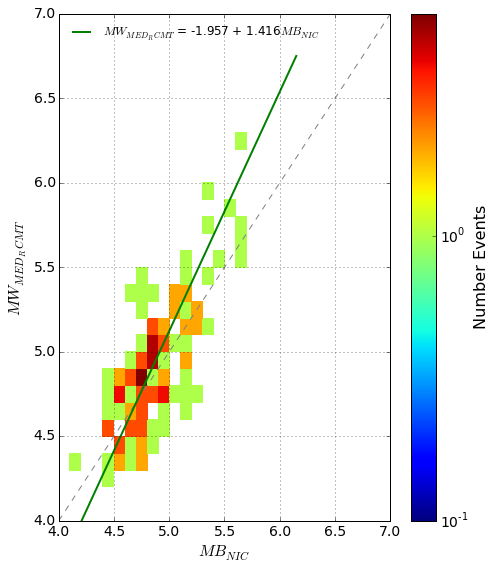

Model standard deviation is 0.276

Agency-Pairs: (BJI, MB) & (MED_RCMT, MW) returned 161 events


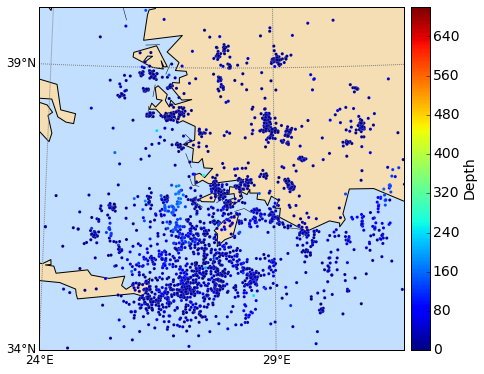

Beta: [-1.76228722  1.36800644]
Beta Std Error: [ 0.4037373   0.08295111]
Beta Covariance: [[ 0.05757775 -0.01181148]
 [-0.01181148  0.00243053]]
Residual Variance: 2.83102095134
Inverse Condition #: 0.00112175999639
Reason(s) for Halting:
  Sum of squares convergence


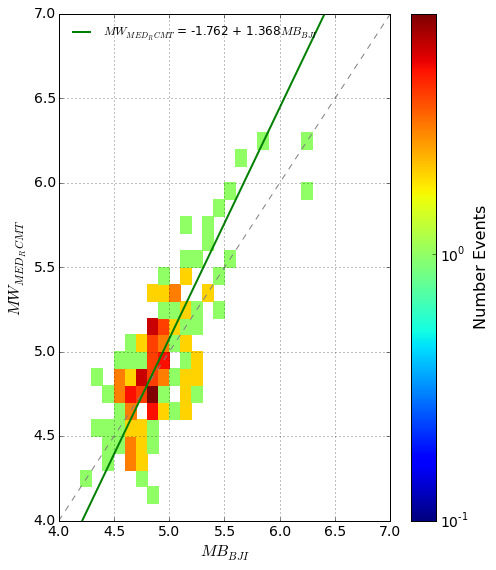

Model standard deviation is 0.283

Agency-Pairs: (CSEM, MB) & (MED_RCMT, MW) returned 120 events


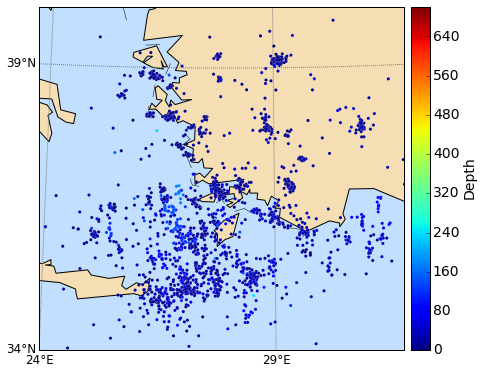

Beta: [-0.09798864  1.03427259]
Beta Std Error: [ 0.26566392  0.05481978]
Beta Covariance: [[ 0.08615862 -0.0177323 ]
 [-0.0177323   0.00366867]]
Residual Variance: 0.819155599248
Inverse Condition #: 0.00146417683918
Reason(s) for Halting:
  Sum of squares convergence


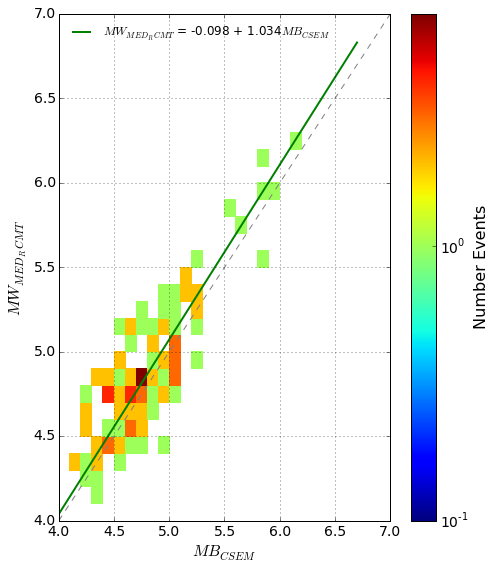

Model standard deviation is 0.218

Agency-Pairs: (ISK, ML) & (MED_RCMT, MW) returned 162 events


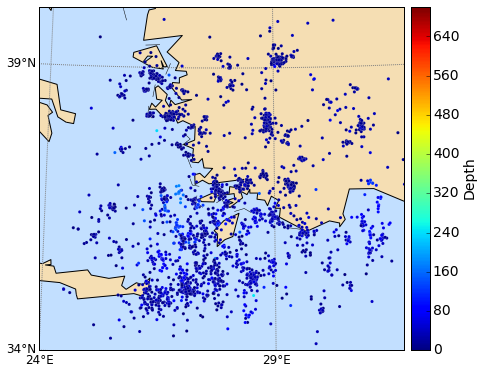

Beta: [ 0.57768751  0.89288115]
Beta Std Error: [ 0.16728942  0.03561615]
Beta Covariance: [[ 0.01402181 -0.00297343]
 [-0.00297343  0.00063557]]
Residual Variance: 1.99587253994
Inverse Condition #: 0.00185785207558
Reason(s) for Halting:
  Sum of squares convergence


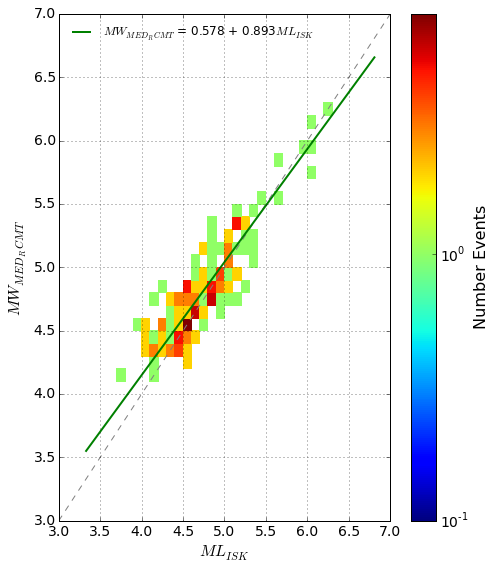

Model standard deviation is 0.188

Agency-Pairs: (ATH, ML) & (MED_RCMT, MW) returned 175 events


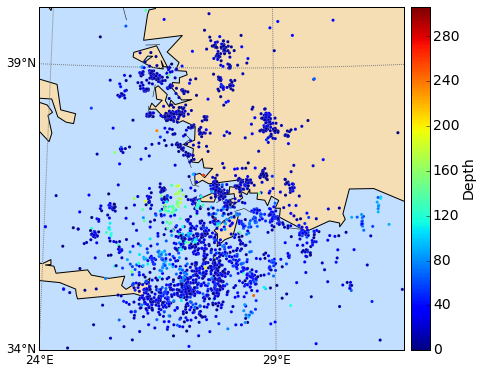

Beta: [ 0.47952155  0.93501892]
Beta Std Error: [ 0.19661951  0.04258258]
Beta Covariance: [[ 0.01474797 -0.0031824 ]
 [-0.0031824   0.00069174]]
Residual Variance: 2.62132497126
Inverse Condition #: 0.00180986420546
Reason(s) for Halting:
  Sum of squares convergence


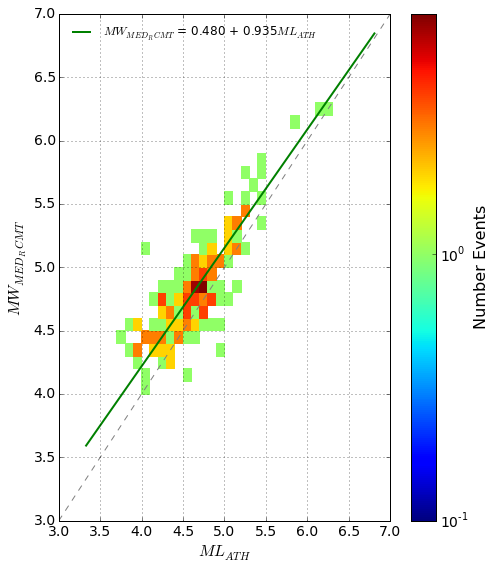

Model standard deviation is 0.22

Agency-Pairs: (THE, ML) & (MED_RCMT, MW) returned 172 events


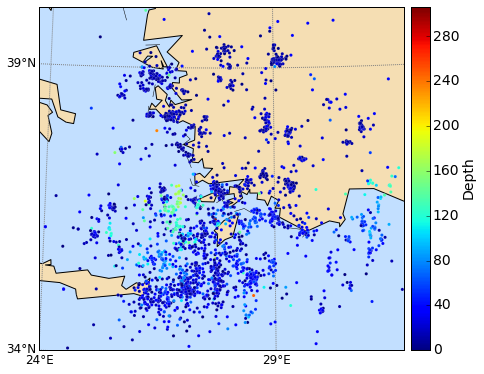

Beta: [ 0.67601226  0.89887527]
Beta Std Error: [ 0.23927508  0.05163537]
Beta Covariance: [[ 0.01832286 -0.00393736]
 [-0.00393736  0.00085328]]
Residual Variance: 3.12465238199
Inverse Condition #: 0.00194302268292
Reason(s) for Halting:
  Sum of squares convergence


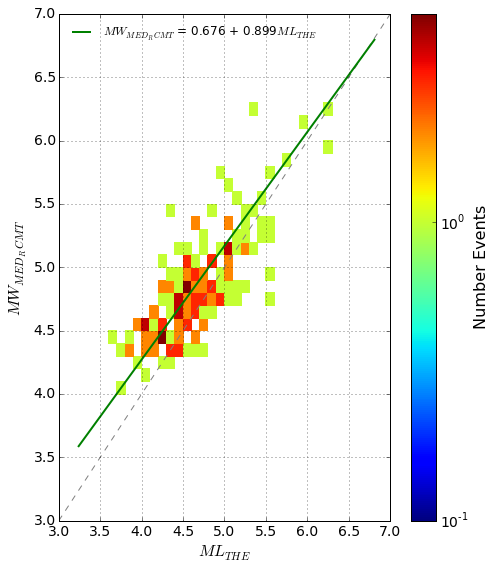

Model standard deviation is 0.275

Agency-Pairs: (DDA, ML) & (MED_RCMT, MW) returned 73 events


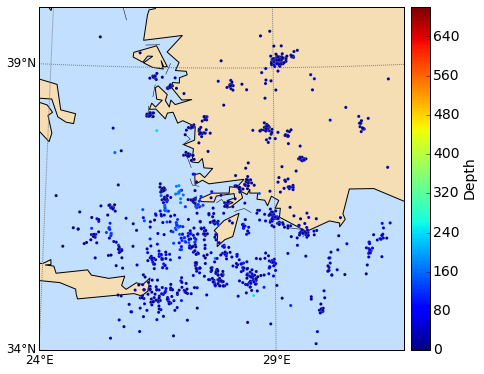

Beta: [ 0.48263497  0.91025555]
Beta Std Error: [ 0.3318286   0.06948852]
Beta Covariance: [[ 0.02578903 -0.00537421]
 [-0.00537421  0.00113092]]
Residual Variance: 4.26965314026
Inverse Condition #: 0.00202578527892
Reason(s) for Halting:
  Sum of squares convergence


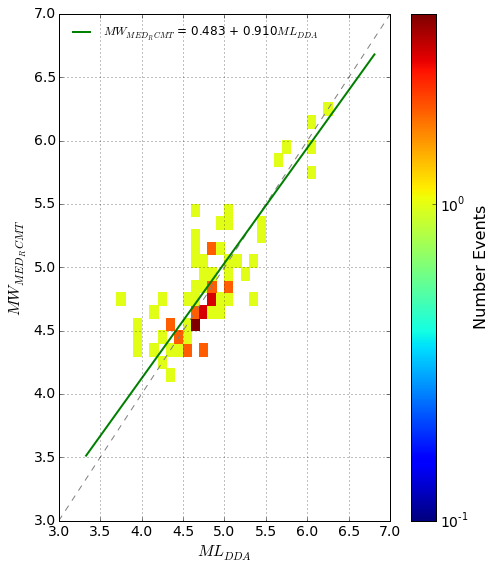

Model standard deviation is 0.276

Agency-Pairs: (IDC, ML) & (MED_RCMT, MW) returned 167 events


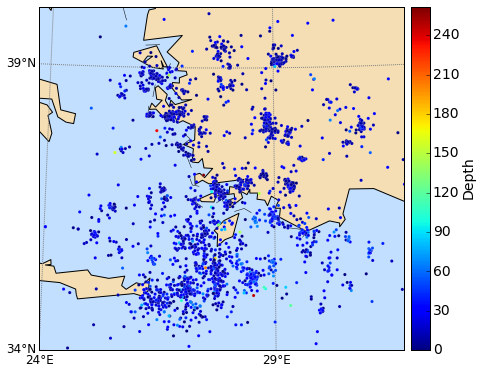

Beta: [-0.23933328  1.23099746]
Beta Std Error: [ 0.47938589  0.11767159]
Beta Covariance: [[ 0.0519809  -0.01272928]
 [-0.01272928  0.00313196]]
Residual Variance: 4.42106343585
Inverse Condition #: 0.00164798553019
Reason(s) for Halting:
  Sum of squares convergence


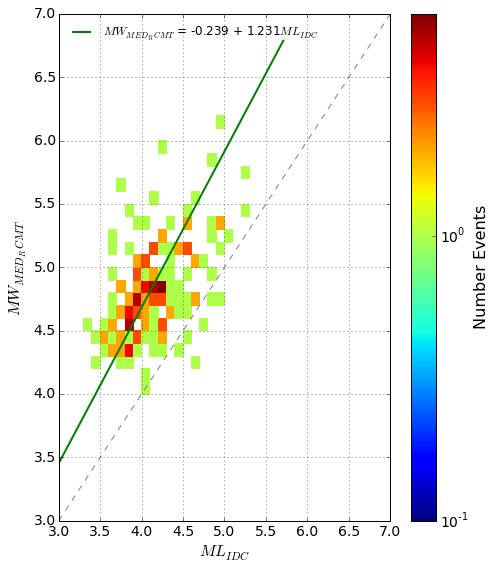

Model standard deviation is 0.421

Agency-Pairs: (NIC, ML) & (MED_RCMT, MW) returned 129 events


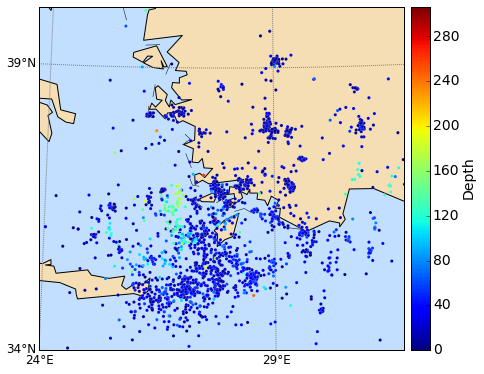

Beta: [-0.08684262  1.09692851]
Beta Std Error: [ 0.32541751  0.07193123]
Beta Covariance: [[ 0.03487995 -0.00769075]
 [-0.00769075  0.00170423]]
Residual Variance: 3.03602954272
Inverse Condition #: 0.00152838281472
Reason(s) for Halting:
  Sum of squares convergence


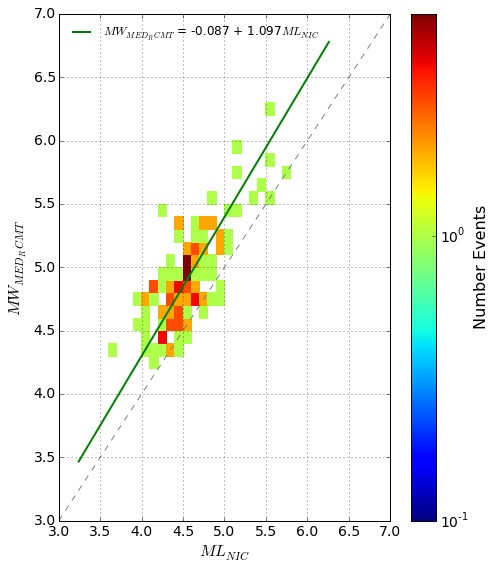

Model standard deviation is 0.261

Agency-Pairs: (HLW, ML) & (MED_RCMT, MW) returned 55 events


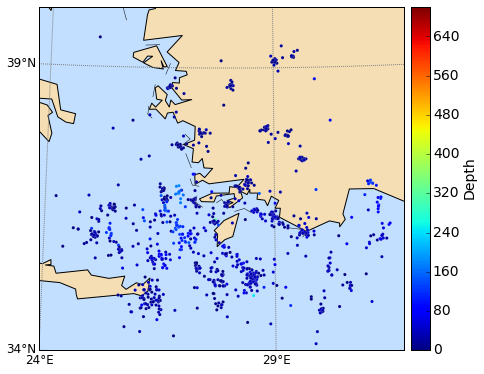

Beta: [ 1.9705476  0.6105757]
Beta Std Error: [ 0.35826973  0.07720005]
Beta Covariance: [[ 0.01733888 -0.0037092 ]
 [-0.0037092   0.00080507]]
Residual Variance: 7.40285350985
Inverse Condition #: 0.00253759389612
Reason(s) for Halting:
  Sum of squares convergence


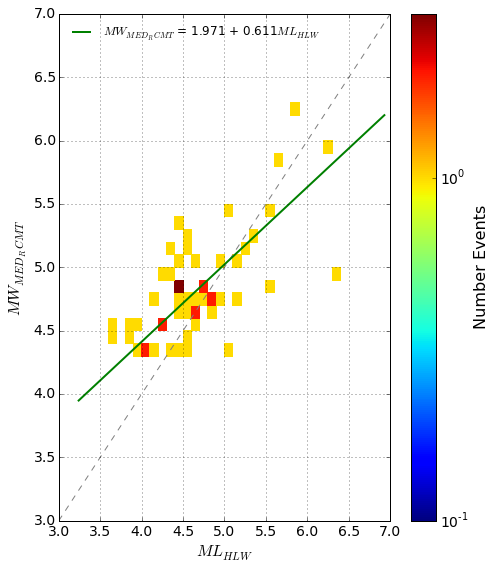

Model standard deviation is 0.313

Agency-Pairs: (CSEM, ML) & (ISK, ML) returned 1969 events


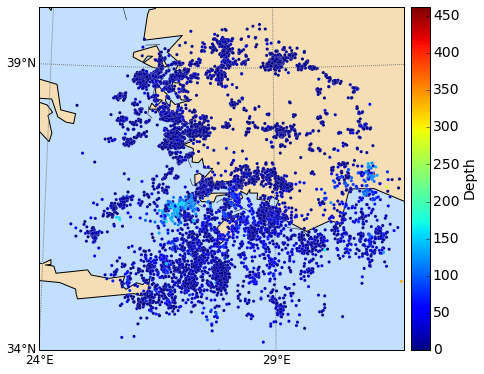

Beta: [ 0.07783727  0.97136937]
Beta Std Error: [ 0.03682593  0.01113942]
Beta Covariance: [[  5.13380565e-04  -1.53777146e-04]
 [ -1.53777146e-04   4.69739838e-05]]
Residual Variance: 2.64160612522
Inverse Condition #: 0.00410853913265
Reason(s) for Halting:
  Sum of squares convergence


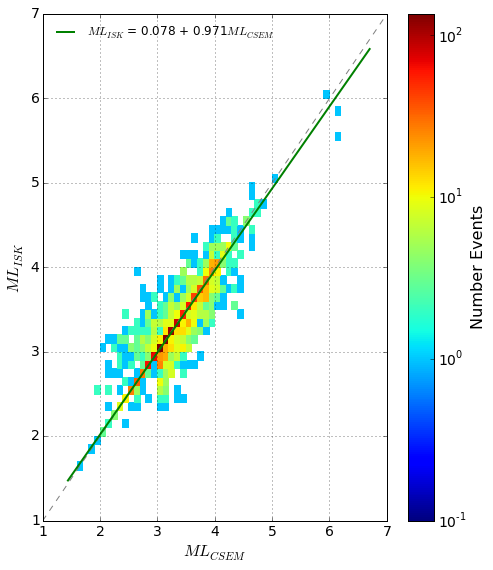

Model standard deviation is 0.229


In [25]:
# now just do a visual comparison, for review
for pair in comparisons:
    print 
    query_mb, cat_mb= cqt.get_agency_magnitude_pairs(
        db1, pair[0], pair[1], no_case=True)
    cqt.plot_catalogue_map(map_config, cat_mb)
    regressor_mb = cqt.CatalogueRegressor(query_mb)
    results_mb = regressor_mb.run_regression("polynomial", [0, 1])
    regressor_mb.results.pprint()
    regressor_mb.plot_model_density(overlay=False, sample=0)
    print "Model standard deviation is " \
        + str(regressor_mb.standard_deviation.round(3))

In [ ]:
# Mw equivalences considered exact after verification
def equivalent(M):
    return M

def zero_sigma(M):
    return 0.0

In [ ]:
def from_NIC_MW(M):
    """
    Agency-Pairs: (NIC, MW) & (MED_RCMT, MW) returned 85 events
    Potential yeild 561 magnitudes
    """
    return 0.9 + M

def from_NIC_MW_sigma(M):
    return 1.0

def from_CSEM_MW(M):
    """
    Agency-Pairs: (CSEM, MW) & (NIC, MW) returned 238 events
    Potential yeild 287 magnitudes
    """
    return from_NIC_MW(M)

def from_CSEM_MW_sigma(M):
    return from_NIC_MW_sigma(M)

def from_IDC_MS(M):
    """
    Agency-Pairs: (IDC, MS) & (MED_RCMT, MW) returned 196 events
    Potential yeild 1279 magnitudes
    """
    return 2.080 + 0.700*M

def from_IDC_MS_sigma(M):
    return 0.2

def from_ISC_MS(M):
    """
    Agency-Pairs: (ISC, MS) & (MED_RCMT, MW) returned 149 events
    Potential yeild 762 magnitudes
    """
    return 2.244 + 0.629*M

def from_ISC_MS_sigma(M):
    return 0.2

def from_ISCJB_MS(M):
    """
    Agency-Pairs: (ISCJB, MS) & (MED_RCMT, MW) returned 79 events
    Potential yeild 403 magnitudes
    """
    return 2.022 + 0.691*M

def from_ISCJB_MS_sigma(M):
    return 0.2

def from_MOS_MS(M):
    """
    Agency-Pairs: (MOS, MS) & (MED_RCMT, MW) returned 64 events
    Potential yeild 291 magnitudes
    """
    return 1.611 + 0.796*M

def from_MOS_MS_sigma(M):
    return 0.3

def from_BJI_MS(M):
    """
    Agency-Pairs: (BJI, MS) & (MED_RCMT, MW) returned 125 events
    Potential yeild 241 magnitudes
    """
    return -0.115 + 1.042*M

def from_BJI_MS_sigma(M):
    return 0.25

def from_CSEM_MS(M):
    """
    Agency-Pairs: (CSEM, MS) & (MED_RCMT, MW) returned 51 events
    Potential yeild 128 magnitudes
    """
    return 2.844 + 0.532*M

def from_CSEM_MS_sigma(M):
    return 0.3

def from_NEIC_MS(M):
    """
    Agency-Pairs: (NEIC, MS) & (MED_RCMT, MW) returned 29 events
    Potential yeild 65 magnitudes
    """
    return 2.345 + 0.612*M

def from_NEIC_MS_sigma(M):
    return 0.5

def from_NEIC_MS(M):
    """
    Agency-Pairs: (NEIC, MS) & (HRVD, MW) returned 23 events
    Potential yeild 65 magnitudes
    """
    return 2.389 + 0.605*M

def from_NEIC_MS_sigma(M):
    return 0.5

def from_IDC_MS(M):
    """
    Agency-Pairs: (IDC, MS) & (ISC, MS) returned 446 events
    Potential yeild 1279 magnitudes
    """
    return from_ISC_MS(M)

def from_IDC_MS_sigma(M):
    return math.sqrt(0.19**2 + from_ISC_MS_sigma(M)**2)

def from_ATH_MD(M):
    """
    Agency-Pairs: (ATH, MD) & (MED_RCMT, MW) returned 87 events
    Potential yeild 14988 magnitudes
    """
    return 0.245 + 1.025*M

def from_ATH_MD_sigma(M):
    return 0.246

def from_ISK_MD(M):
    """
    Agency-Pairs: (ISK, MD) & (MED_RCMT, MW) returned 55 events
    Potential yeild 17210 magnitudes
    """
    return 0.009 + 1.070*M

def from_ISK_MD_sigma(M):
    return 0.27

def from_HLW_MD(M):
    """
    Agency-Pairs: (HLW, MD) & (MED_RCMT, MW) returned 47 events
    Potential yeild 510 magnitudes
    """
    return 0.2 + M

def from_HLW_MD_sigma(M):
    return 0.7

def from_DDA_MD(M):
    """
    Agency-Pairs: (DDA, MD) & (MED_RCMT, MW) returned 23 events
    Potential yeild 6172 magnitudes
    """
    return 0.7 + M

def from_DDA_MD_sigma(M):
    return 0.5

def from_GII_MD(M):
    """
    Agency-Pairs: (GII, MD) & (MED_RCMT, MW) returned 34 events
    Potential yeild 241 magnitudes
    """
    return 1.388 + 0.776*M

def from_GII_MD_sigma(M):
    return 0.4

def from_CSEM_MD(M):
    """
    Agency-Pairs: (CSEM, MD) & (ISK, MD) returned 8512 events
    Potential yeild 10863 magnitudes
    """
    return from_ISK_MD(M)

def from_CSEM_MD_sigma(M):
    return math.sqrt(0.129**2 + from_ISK_MD_sigma(M)**2)

def from_ISC_MB(M):
    """
    Agency-Pairs: (ISC, MB) & (MED_RCMT, MW) returned 182 events
    Potential yeild 3953 magnitudes
    """
    return 0.108 + 1.015*M

def from_ISC_MB_sigma(M):
    return 0.224

def from_IDC_MB(M):
    """
    Agency-Pairs: (IDC, MB) & (MED_RCMT, MW) returned 205 events
    Potential yeild 2455 magnitudes
    """
    return 0.197 + 1.056*M

def from_IDC_MB_sigma(M):
    return 0.241

def from_NEIC_MB(M):
    """
    Agency-Pairs: (NEIC, MB) & (MED_RCMT, MW) returned 182 events
    Potential yeild 1849 magnitudes
    """
    return 0.113 + 1.005*M

def from_NEIC_MB_sigma(M):
    return 0.225

def from_ISCJB_MB(M):
    """
    Agency-Pairs: (ISCJB, MB) & (MED_RCMT, MW) returned 91 events
    Potential yeild 1161 magnitudes
    """
    return 0.110 + 1.017*M

def from_ISCJB_MB_sigma(M):
    return 0.2

def from_MOS_MB(M):
    """
    Agency-Pairs: (MOS, MB) & (MED_RCMT, MW) returned 189 events
    Potential yeild 936 magnitudes
    """
    return 0.334 + 0.927*M

def from_MOS_MB_sigma(M):
    return 0.225

def from_NIC_MB(M):
    """
    Agency-Pairs: (NIC, MB) & (MED_RCMT, MW) returned 128 events
    Potential yeild 689 magnitudes
    """
    return -1.957 + 1.416*M

def from_NIC_MB_sigma(M):
    return 0.276

def from_BJI_MB(M):
    """
    Agency-Pairs: (BJI, MB) & (MED_RCMT, MW) returned 161 events
    Potential yeild 602 magnitudes
    """
    return -1.762 + 1.368*M

def from_BJI_MB_sigma(M):
    return 0.283

def from_CSEM_MB(M):
    """
    Agency-Pairs: (CSEM, MB) & (MED_RCMT, MW) returned 120 events
    Potential yeild 425 magnitudes
    """
    return -0.098 + 1.034*M

def from_CSEM_MB_sigma(M):
    return 0.218

def from_ISK_ML(M):
    """
    Agency-Pairs: (ISK, ML) & (MED_RCMT, MW) returned 162 events
    Potential yeild 6545 magnitudes
    """
    return 0.578 + 0.893*M

def from_ISK_ML_sigma(M):
    return 0.188

def from_ATH_ML(M):
    """
    Agency-Pairs: (ATH, ML) & (MED_RCMT, MW) returned 175 events
    Potential yeild 6365 magnitudes
    """
    return 0.480 + 0.935*M

def from_ATH_ML_sigma(M):
    return 0.22

def from_THE_ML(M):
    """
    Agency-Pairs: (THE, ML) & (MED_RCMT, MW) returned 172 events
    Potential yeild 4637 magnitudes
    """
    return 0.676 + 0.899*M

def from_THE_ML_sigma(M):
    return 0.275

def from_DDA_ML(M):
    """
    Agency-Pairs: (DDA, ML) & (MED_RCMT, MW) returned 73 events
    Potential yeild 3350 magnitudes
    """
    return 0.483 + 0.910*M

def from_DDA_ML_sigma(M):
    return 0.276

def from_IDC_ML(M):
    """
    Agency-Pairs: (IDC, ML) & (MED_RCMT, MW) returned 167 events
    Potential yeild 2050 magnitudes
    """
    return -0.239 + 1.231*M

def from_IDC_ML_sigma(M):
    return 0.421

def from_NIC_ML(M):
    """
    Agency-Pairs: (NIC, ML) & (MED_RCMT, MW) returned 129 events
    Potential yeild 1147 magnitudes
    """
    return -0.087 + 1.097*M

def from_NIC_ML_sigma(M):
    0.261

def from_HLW_ML(M):
    """
    Agency-Pairs: (HLW, ML) & (MED_RCMT, MW) returned 55 events
    Potential yeild 589 magnitudes
    """
    return 0.3 + M

def from_HLW_ML_sigma(M):
    return 0.313

def from_CSEM_ML(M):
    """
    Agency-Pairs: (CSEM, ML) & (ISK, ML) returned 1969 events
    Potential yeild 2999 magnitudes
    """
    return from_ISK_ML(M)

def from_CSEM_ML_sigma(M):
    return math.sqrt(0.229**2 + from_ISK_ML_sigma(M)**2)

In [ ]:
from eqcat.isc_homogenisor import \
    MagnitudeConversionRule, DynamicHomogenisor, HomogenisorPreprocessor

In [ ]:
# origin rules

origin_rules = [
    ("1900/10/01 - 2015/10/01", [
            "MED_RCMT", "ZUR_RMT", "GCMT", "HRVD", "NEIC",
            "ISK", "ISCJB", "ISC", "IDC", "IDC", "ATH", 
            "MOS", "GII", "DDA", "THE", "BJI", "HLW", "CSEM", "NIC"])
]

In [ ]:
magnitude_rule_set = [
    MagnitudeConversionRule("MED_RCMT", "MW", equivalent, zero_sigma),
    MagnitudeConversionRule("ZUR_RMT", "MW", equivalent, zero_sigma),
    MagnitudeConversionRule("GCMT", "MW", equivalent, zero_sigma),
    MagnitudeConversionRule("HRVD", "MW", equivalent, zero_sigma),
    MagnitudeConversionRule("NEIC", "MW", equivalent, zero_sigma),
        
    MagnitudeConversionRule("ISK",  "ML", from_ISK_ML, from_ISK_ML_sigma), # 0.188  
    
    MagnitudeConversionRule("ISCJB", "MB", from_ISCJB_MB, from_ISCJB_MB_sigma), # 0.2
    MagnitudeConversionRule("CSEM", "MB", from_CSEM_MB, from_CSEM_MB_sigma), # 0.218
    MagnitudeConversionRule("ATH",  "ML", from_ATH_ML, from_ATH_ML_sigma), # 0.22
    MagnitudeConversionRule("GII",  "MB", from_ISC_MB, from_ISC_MB_sigma), # 0.224
    MagnitudeConversionRule("NEIC", "MB", from_NEIC_MB, from_NEIC_MB_sigma), # 0.225
    MagnitudeConversionRule("MOS",  "MB", from_MOS_MB, from_MOS_MB_sigma), # 0.225
    MagnitudeConversionRule("GII",  "MB", from_IDC_MB, from_IDC_MB_sigma), # 0.241
    MagnitudeConversionRule("ATH",  "MD", from_ATH_MD, from_ATH_MD_sigma), # 0.246
    MagnitudeConversionRule("IDC",  "MS", from_IDC_MS, from_IDC_MS_sigma), # 0.25
    MagnitudeConversionRule("ISC",  "MS", from_ISC_MS, from_ISC_MS_sigma), # 0.25
    MagnitudeConversionRule("ISCJB", "MS", from_ISCJB_MS, from_ISCJB_MS_sigma), # 0.25 
    MagnitudeConversionRule("NIC",  "ML", from_NIC_ML, from_NIC_ML_sigma), # 0.261
    MagnitudeConversionRule("ISK",  "MD", from_ISK_MD, from_ISK_MD_sigma), # 0.27
    MagnitudeConversionRule("THE",  "ML", from_THE_ML, from_THE_ML_sigma), # 0.275
    MagnitudeConversionRule("DDA",  "ML", from_DDA_ML, from_DDA_ML_sigma), # 0.276
    MagnitudeConversionRule("NIC",  "MB", from_NIC_MB, from_NIC_MB_sigma), # 0.276
    MagnitudeConversionRule("BJI",  "MB", from_BJI_MB, from_BJI_MB_sigma), # 0.283
    
    MagnitudeConversionRule("MOS",  "MS", from_MOS_MS, from_MOS_MS_sigma), # 0.3
    MagnitudeConversionRule("HLW",  "ML", from_HLW_ML, from_HLW_ML_sigma), # 0.313
    MagnitudeConversionRule("BJI",  "MS", from_BJI_MS, from_BJI_MS_sigma), # 0.35
    MagnitudeConversionRule("CSEM", "MS", from_CSEM_MS, from_CSEM_MS_sigma), # 0.35
    
    MagnitudeConversionRule("CSEM", "ML", from_CSEM_ML, from_CSEM_ML_sigma), # 0.4
    MagnitudeConversionRule("GII",  "MD", from_GII_MD, from_GII_MD_sigma), # 0.4
    MagnitudeConversionRule("IDC",  "ML", from_IDC_ML, from_IDC_ML_sigma), # 0.421   
    
    MagnitudeConversionRule("NEIC", "MS", from_NEIC_MS, from_NEIC_MS_sigma), # 0.5    
    MagnitudeConversionRule("DDA",  "MD", from_DDA_MD, from_DDA_MD_sigma), # 0.5
    MagnitudeConversionRule("CSEM", "MD", from_CSEM_MD, from_CSEM_MD_sigma), # 0.5
    
    MagnitudeConversionRule("HLW",  "MD", from_HLW_MD, from_HLW_MD_sigma), # 0.7
    
    MagnitudeConversionRule("CSEM", "MW", from_CSEM_MW, from_CSEM_MW_sigma), # 1.0
    MagnitudeConversionRule("NIC",  "MW", from_CSEM_ML, from_NIC_MW_sigma), # 1.0
]

In [ ]:
magnitude_rules = [
    ("1900/10/01 - 2015/10/01", magnitude_rule_set)
]

In [ ]:
preprocessor = HomogenisorPreprocessor(rule_type="time")
preprocessed_catalogue = preprocessor.execute(
    catalogue, origin_rules, magnitude_rules)
homogenisor = DynamicHomogenisor(preprocessed_catalogue, logging=True)

In [ ]:
output_catalogue = homogenisor.homogenise(magnitude_rules, origin_rules);

In [ ]:
log_file_name = os.path.splitext(base)[0] + '_logfile.csv'
homogenisor.dump_log(log_file_name)
homogenised_file_name = os.path.splitext(base)[0] + '_homogenised.csv'
homogenisor.export_homogenised_to_csv(homogenised_file_name)